## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single URL
* "➋" represents a single mention of username (e.g. "@noah")

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from os.path import basename, splitext
from random import choice, sample
from nltk.corpus import stopwords
from string import punctuation
from pprint import pprint
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [4]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

In [5]:
names = open("../data/other_data/first_names.txt").read().split("\n")
names_pattern = re.compile(r'\b(?:{})\b'.format('|'.join(names)))

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer()

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("display.height", 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 1000)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 10% English words
#### Also, make the mentions of usernames, names, and URLs generic

In [10]:
def load_data(filename, threshold=0.1):
    data = [(urls_pattern.sub("➊", 
             at_mentions_pattern.sub("➋", 
             names_pattern.sub("➌",
             t["tweet_data"]["full_text"])))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["lang"] == "en" 
            and t["reply"]["lang"] == "en" 
            and t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [11]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [12]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Remove tweets which are present in both datasets

In [13]:
%%time
subtweets_data = [tweet for tweet in subtweets_data if tweet not in non_subtweets_data]

CPU times: user 7.06 s, sys: 27.8 ms, total: 7.09 s
Wall time: 7.09 s


In [14]:
%%time
non_subtweets_data = [tweet for tweet in non_subtweets_data if tweet not in subtweets_data]

CPU times: user 4.7 s, sys: 18.2 ms, total: 4.72 s
Wall time: 4.73 s


#### Show examples

In [15]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
#SignsYouAreInAHorrorMovie  waking up and the odor of human waste and burnt popcorn are only superceded by Fox News playing on the tv at full volume


In [16]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
So PayPal just up and TOOK almost $1000 from my account....


#### Find the length of the smaller dataset

In [17]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [18]:
subtweets_data = sample(subtweets_data, smallest_length)

In [19]:
non_subtweets_data = sample(non_subtweets_data, smallest_length)

In [20]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 11288


#### Prepare data for training

In [21]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [22]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [23]:
training_data = subtweets_data + non_subtweets_data

#### Build the pipeline

In [24]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words="english")),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [25]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    
    test_accuracies = []
    train_accuracies = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
                
        test_accuracy = accuracy_score(class_test, predictions_test)
        test_accuracies.append(test_accuracy)
        print("Test Data Accuracy: {:.4f}\n".format(test_accuracy))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
                
        train_accuracy = accuracy_score(class_train, predictions_train)
        train_accuracies.append(train_accuracy)
        print("Train Data Accuracy: {:.4f}\n".format(train_accuracy))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [26]:
%%time
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.7083    0.6835    0.6957      1087
    subtweet     0.7155    0.7387    0.7269      1171

 avg / total     0.7120    0.7121    0.7119      2258

Test Data Accuracy: 0.7121

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9804    0.9846    0.9825     10201
    subtweet     0.9844    0.9801    0.9823     10117

 avg / total     0.9824    0.9824    0.9824     20318

Train Data Accuracy: 0.9824

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.7439    0.7189    0.7312      1103
    subtweet     0.7399    0.7636    0.7516      1155

 avg / total     0.7419    0.7418    0.7416      2258

Test Data Accuracy: 0.7418

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9810    0.9854    0.9832     10185
    subtweet     0.9852    0.9809    0.9830     10133



#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [27]:
def most_informative_features(pipeline, n=15000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [28]:
%%time
most_informative_features_all = most_informative_features(sentiment_pipeline)

CPU times: user 2.5 s, sys: 66.5 ms, total: 2.56 s
Wall time: 2.78 s


In [29]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [30]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [31]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(50)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! #absapremiership,-13.0557,.,-7.6598
1,! ! #brooklyn99,-13.0557,",",-8.0144
2,! ! #cholecystectomy,-13.0557,➊,-8.0471
3,! ! #fbr,-13.0557,"""",-8.1494
4,! ! #goblue,-13.0557,people,-8.4324
5,! ! #goldenkamuy,-13.0557,?,-8.5620
6,! ! #letsgoflyers,-13.0557,like,-8.6762
7,! ! #magistratepico,-13.0557,don't,-8.6962
8,! ! #manila,-13.0557,just,-8.7244
9,! ! #miz,-13.0557,i'm,-8.8360


#### Define function for visualizing confusion matrices

In [32]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

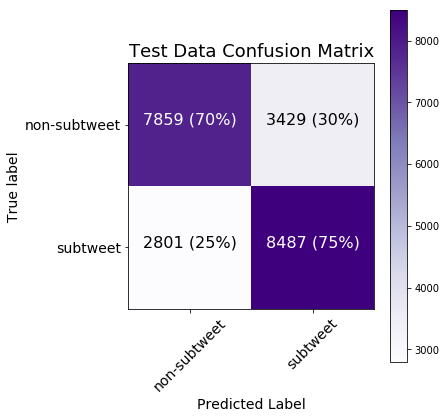

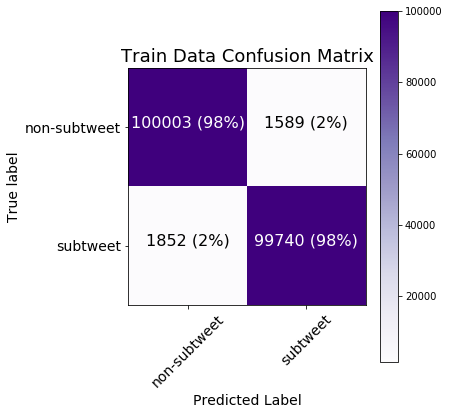

In [33]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [34]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [35]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [36]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➊")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(names_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [37]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [38]:
%%time
dataframes = process_tweets_for_testing(filenames)

CPU times: user 10.2 s, sys: 204 ms, total: 10.4 s
Wall time: 11 s


#### Show a random table

In [39]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
352,"Saying ""luv u"" instead of ""I love you"" bc somehow that's less vulnerable",2015-02-18 17:54:43,0,1,568181848175722496,0.8708
495,There are literally ppl out there who refuse to get their kids vaccinated bc of autism and if that doesn't make you angry then ur awful,2014-10-17 01:13:57,0,0,522978800377004032,0.8582
28,ye identity politics are flawed n tbh p annoying but saying that theyre trash all together is p much telling disenfranchised ppl to shut up,2017-04-21 21:57:11,0,0,855601344522051584,0.8553
216,too many posts abt bein depressed on tumblr. i know i am depressed i dont need u n ur emojis to remind me,2015-08-25 16:23:59,2,0,636272832041865216,0.8543
122,every man who said caring abt bey's twins is dumb but filled all my social media w superbowl stuff is a damn hypocrite,2017-02-06 07:19:08,2,0,828578773960306689,0.8483


#### Prepare statistics on tweets

In [40]:
tests_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [41]:
test_df_stats = tests_df.describe()

In [42]:
test_df_stats.columns = ["User {}".format(i + 1) for i, column in enumerate(test_df_stats.columns)]

In [43]:
test_df_stats

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8,User 9,User 10,User 11,User 12,User 13,User 14
count,621.0000,2640.0000,2066.0000,3488.0000,4356.0000,1939.0000,1169.0000,638.0000,2814.0000,445.0000,772.0000,5364.0000,853.0000,1467.0000
mean,0.5204,0.5105,0.5614,0.5189,0.5285,0.4909,0.4286,0.5456,0.5140,0.4165,0.5455,0.5071,0.5532,0.5366
std,0.1217,0.1329,0.1216,0.1307,0.1109,0.1267,0.1161,0.1298,0.1264,0.1167,0.1254,0.1286,0.1272,0.1259
min,0.1134,0.0631,0.0917,0.0813,0.0660,0.0376,0.0236,0.0961,0.0365,0.0549,0.1188,0.0427,0.1073,0.0532
25%,0.4386,0.4241,0.4798,0.4313,0.4549,0.4105,0.3505,0.4597,0.4288,0.3459,0.4607,0.4259,0.4732,0.4626
50%,0.5212,0.5164,0.5595,0.5245,0.5272,0.4928,0.4325,0.5485,0.5199,0.4204,0.5373,0.5047,0.5591,0.5352
75%,0.6036,0.5998,0.6431,0.6113,0.6007,0.5751,0.5072,0.6342,0.5991,0.5001,0.6268,0.5913,0.6379,0.6215
max,0.8684,0.9278,0.8946,0.8932,0.8991,0.8924,0.8159,0.8708,0.8968,0.7340,0.8754,0.9263,0.8624,0.9111


#### Plot a histogram with three random users

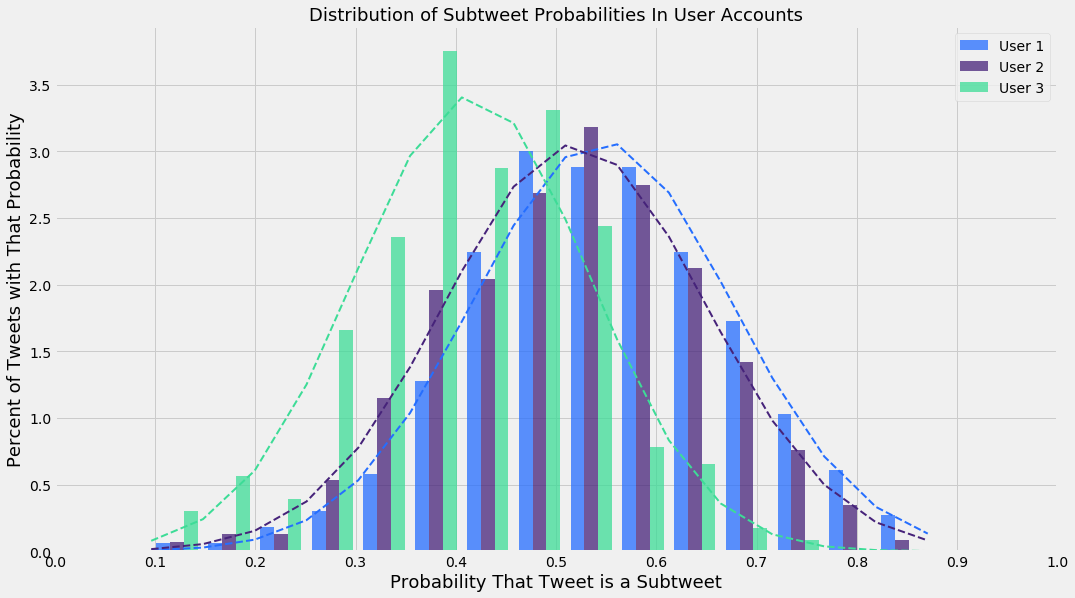

In [44]:
random_choices = sample(list(dataframes.values()), 3)
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in random_choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["User 1", "User 2", "User 3"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in random_choices]

line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#256EFF", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#46237A", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [45]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [46]:
new_tests_df_stats

,SubtweetProbability
count,28632.0000
mean,0.5161
std,0.1280
min,0.0236
25%,0.4342
50%,0.5180
75%,0.6014
max,0.9278


#### Now plot

No handles with labels found to put in legend.


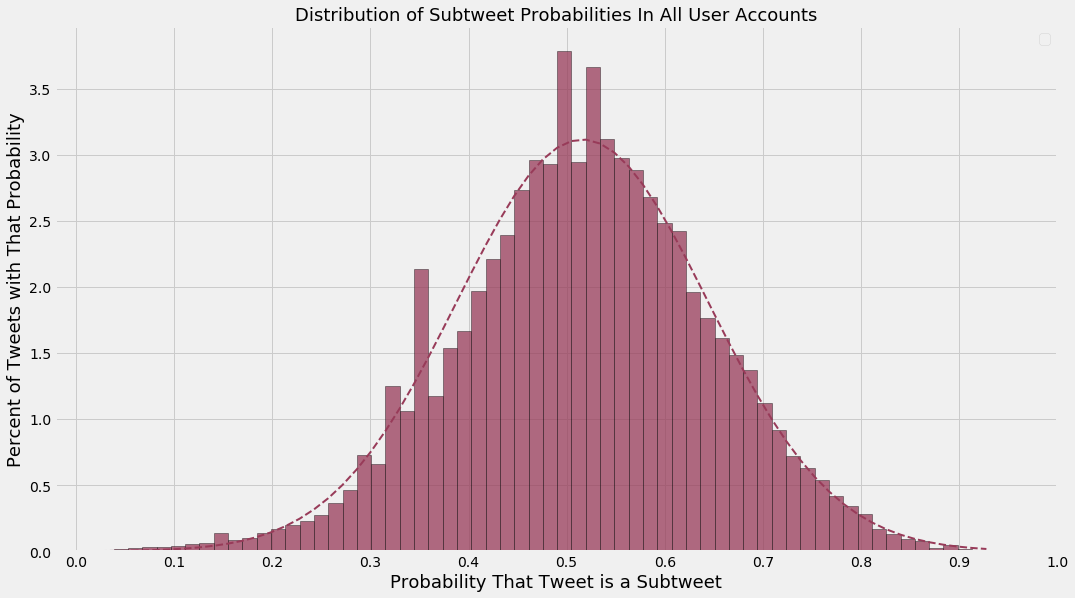

In [47]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#983B59",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)

line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                              new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#983B59", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [48]:
training_data = [(tweet[0]
                  .replace("➊", "")
                  .replace("➋", "")
                  .replace("➌", "")) for tweet in training_data]

#### Lengths

In [49]:
length_data = [len(tweet) for tweet in training_data]

In [50]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [51]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [52]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [53]:
length_data = length_data_for_stats.Length.tolist()

#### Top 5 longest tweets

In [54]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
16452,293,That's what gets me WHY low Brow him ?? Why By all that's right he should be impeachedhe is still involves himself in business foreignCabinet heads are just as slimy with using planes etc his disregard for bills Pres o put in 4 protecting us!!
1037,281,"I'm starting to get a couple questions about it since May is coming up so I might as well let you guys know: there will not be a MIAMAFV 2 this year (at least not that exact event).\n\nWho knows what's to come in the future, but right now I've got to take care of other stuff first."
12399,281,"Enthralled by Raja Shiv Chhatrapati, a well mounted magnum opus on life of the Maratha warrior at Red Fort. Vividly brought out his philosophies, struggles, inspiration from mother Jijayee & penchant for gender equality through well conceived music, dance & dialogues. A must see!"
14249,281,"The numbers don't lie: more evidence the #GOPTaxScam was designed to tip the scales in favor of the wealthiest Americans at the expense of the middle-class. From day one, Americans knew Republicans gave them a raw deal, one of the clearest reasons why the law remains so unpopular"
21145,281,"Actually, he and his staff float theories until 3 pm every day, whatever gets the most likes on Twitter is the storyline they go with. \n\nSo, comparing him to sourced journalists (as in this tweet) is ignorant. \n\nDotcom is a hacker on Twitter. Period.\n\nSorry about your education."


#### Top 5 shortest tweets

In [55]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
17802,4,fear
7678,4,Ugly
9702,4,Rude
9708,4,Lame
10150,4,soft


#### Tweet length statistics

In [56]:
length_data_for_stats.describe()

,Length
count,22576.0000
mean,103.6937
std,73.5124
min,4.0000
25%,46.0000
50%,83.0000
75%,144.0000
max,293.0000


#### Punctuation

In [57]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [58]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 5 most punctuated tweets

In [59]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
4132,13,"IF U WERE KILLED TOMORROW, I WOULDNT GO 2 UR FUNERAL CUZ ID B N JAIL 4 KILLIN DA PERSON THAT KILLED U!\n......__________________ \n...../_==o;;;;;;;;______[]\n.....), —-.(_(__) / \n....// (..) ), —--"" \n...//___// \n..//___// \nWE TRUE HOMIES WE RIDE TOGETHER WE DIE TOGETHER"
14744,11,(•_•)\n<) )\ I am no Wonder Woman\n / \\n\n\(•_•)\n ( (> I am not Supergirl\n / \\n\n\(-_•)/\n OO I am Power Girl!\n ) ( \n / \\n\n (•_•)\n <OO> #Bitchez \n ) (\n | |
13322,11,"Going to go ahead and crown myself the absolute emperor of finding things on menus that sound interesting, deciding I would like to try them, then being told ""I'm sorry sir, that's actually not available...""\n\n[ then why the @#$% is it ON YOUR MENUUUUUUUU-- ]"
22272,10,I created an equation to find the largest meaningful number in the observable universe.\n\nVolume Quantitative Infinity [vQ(inf)]= (4/3)(pi)ct^3\n\nI'll explain it in a thread. (1/?)
11656,10,"Billboard Hot 100: #62(-3) Tell Me You Love Me, [19 weeks]. *peak: #53*"


#### Tweets punctuation statistics

In [60]:
punctuation_data_for_stats.describe()

,Punctuation
count,22576.0000
mean,1.9806
std,1.6363
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,13.0000


#### Stop words

In [61]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [62]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 5 tweets with most stop words

In [63]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
11288,8,"Pentagon: Master Sergeant J. Dunbar, assigned to Headquarters, U.S. Army Special Operations Command, Fort Bragg, N.C., was KIA Mar. 30, while deployed in support of Operation Inherent Resolve. Dunbar died from wounds received during combat operations near Manbij, Syria."
12695,8,She needs to know that trump is not the way to go in Colorado
12677,8,"The racial mass shooting in Nashville, & the Nazi rally in Ga, this weekend, followed by Confederate Memorial Day today is ALL CONNECTED. This was like a 3 day white supremacist holiday weekend"
12678,8,"Hey brother, I'm looking to be up that way next month, on a bit of a footballing road trip. I realise DDL aren't the Dynamo but what say we go see the DDL host WV?"
12679,8,I'm deliberately hiding my soul from


#### Top 5 tweets with fewest stop words

In [64]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
5539,0,Clever.
4201,0,fuck
6000,0,fuck u
6681,0,We been knew
15460,0,When ?


#### Tweets stop words statistics

In [65]:
stop_words_data_for_stats.describe()

,Stop words
count,22576.0000
mean,7.0941
std,1.3557
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [66]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [67]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [68]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [69]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 5 tweets with most unique words

In [70]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
19466,"GIVE AWAY!\n\nThe rules are really easy, all you have to do is :\n1. Must be following me (i check) \n2. RT and fav this tweet\n3. tag your mutuals/anyone\n4. only 1 winner! \n5. i ship worldwide;) \n\nit ends in 8th May 2018 or when this tweet hit 2k RT and like!\n\nGood luck! ❤",59
1037,"I'm starting to get a couple questions about it since May is coming up so I might as well let you guys know: there will not be a MIAMAFV 2 this year (at least not that exact event).\n\nWho knows what's to come in the future, but right now I've got to take care of other stuff first.",59
275,"Crazy how wrong u can be about someone. A girl I graduated w/ was always doing drugs& got pregnant at 16. I assumed she'd end up being a loser but it turn out she now has 4 beautiful kids& is making over $4,500/month just off of child support payments from the 3 different dads",58
17405,"ur bday 21/8 u50. Fancy a kick about the park where we used to play.?Jumpers down- shots.Then 3 holes of golf.we hit any windows we run!What do u say- will be a laugh.I am 50 a week later.hey, we're still kind of fit:))give me a shout if up 4 it 07532203285 Liam",58
2914,"got into a tepid back nd forth w/ a uknowwhoAJ+columnist bc i said they steal their ""hot takes"" from blk twitter & alike. wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is Post Colonial Memes for Oriental Minded T-",57


#### Top 5 tweets with fewest unique words

In [71]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
17802,fear,1
6646,Gross,1
14074,enjoy,1
11308,hello,1
976,Thread,1


#### Tweets unique words statistics

In [72]:
unique_words_data_for_stats.describe()

,Unique words
count,22576.0000
mean,18.7833
std,12.0554
min,1.0000
25%,9.0000
50%,16.0000
75%,26.0000
max,59.0000


#### Plot them

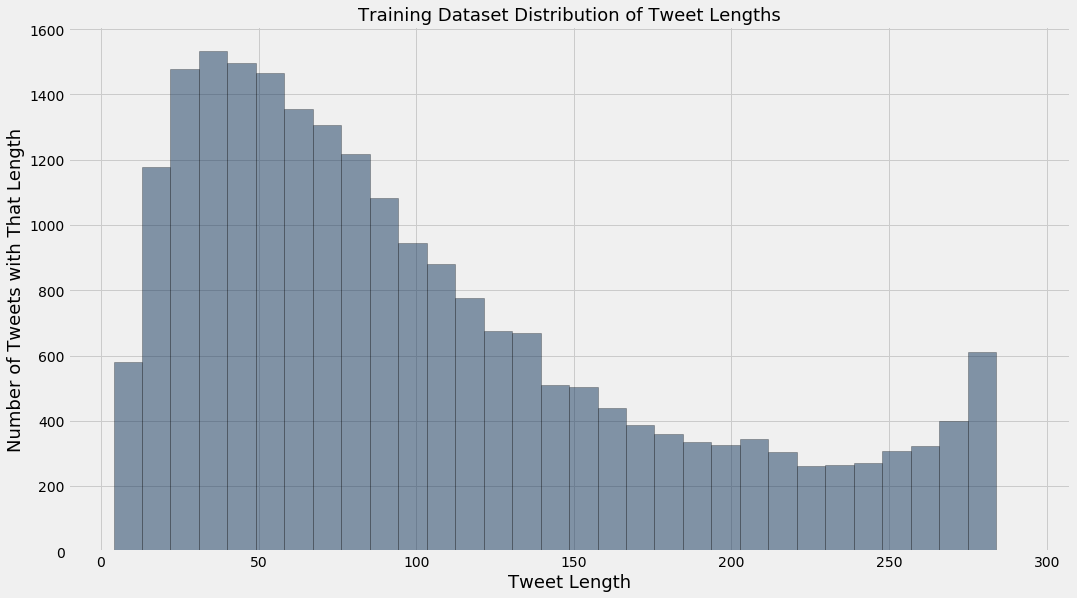

In [73]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#12355b", 
                           alpha=0.5)

# length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
# ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

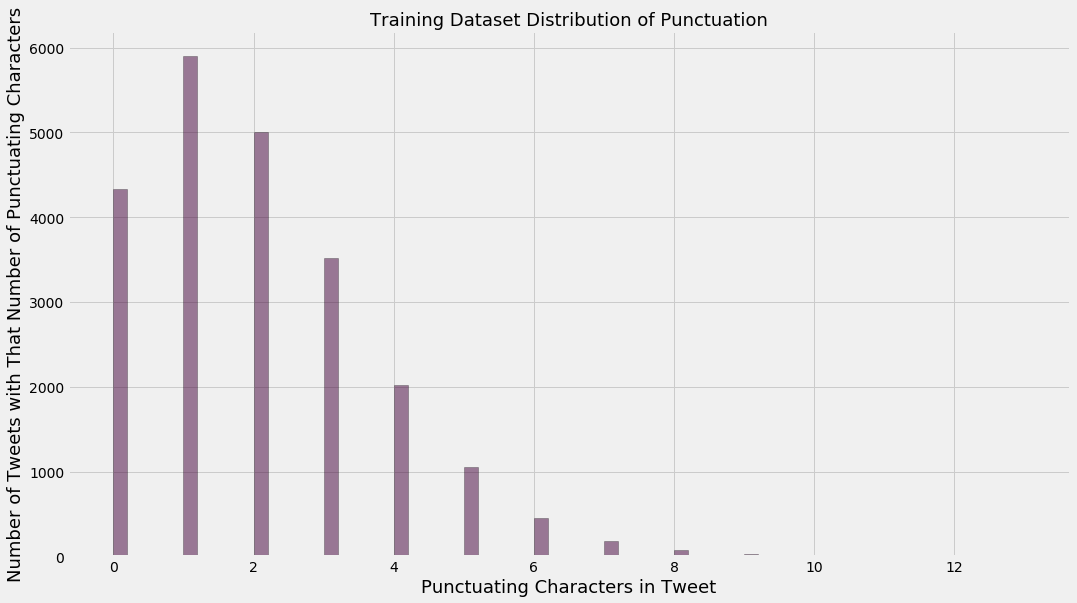

In [74]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott",
                           edgecolor="black", 
                           # density=True, 
                           color="#420039",
                           alpha=0.5)

# punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
# ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

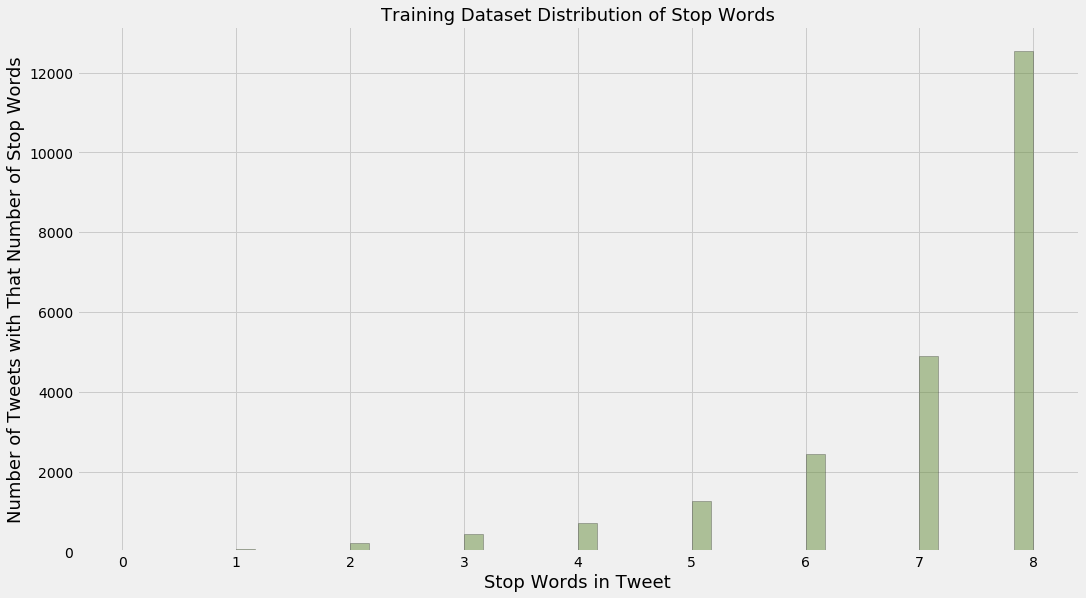

In [75]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#698f3f",
                           alpha=0.5)

# stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
# ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

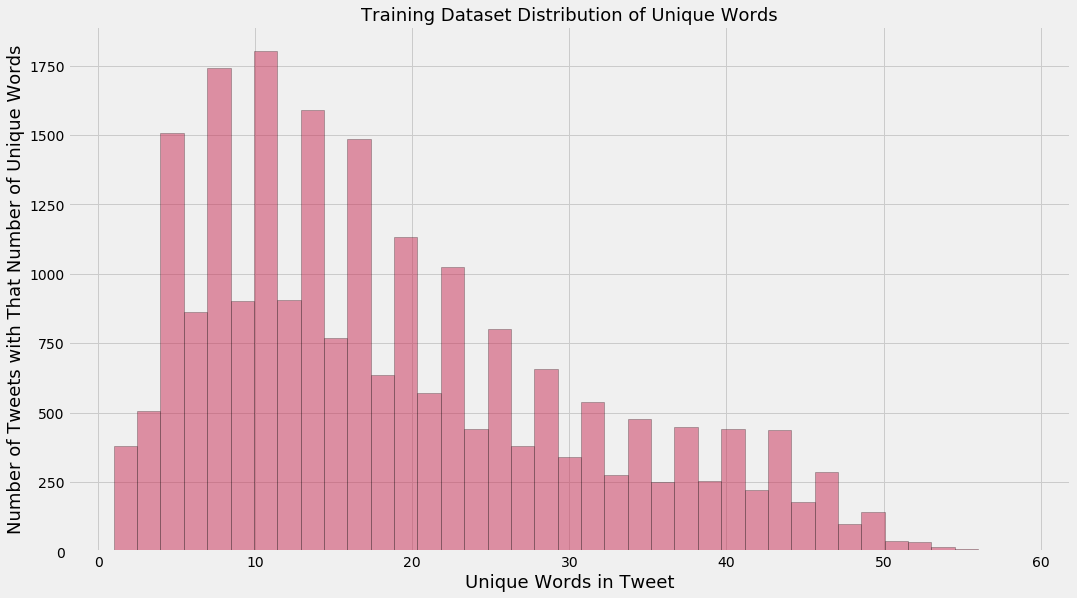

In [76]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#ca2e55",
                           alpha=0.5)

# unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
# ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique Words", fontsize=18)

plt.show()